In [1]:
#conda install -c conda-forge jupyter_contrib_nbextensions

In [2]:
#pip install autopep8

## Импорт библиотек и определение основных настроек

In [3]:
from IPython.display import Markdown, display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
import warnings
import random
warnings.simplefilter('ignore')

pd.set_option('display.max_rows', (50))  # показывать 50 строк
pd.set_option('display.max_columns', (50))  # показывать 50 колонок

def printmd(string):
    display(Markdown(string))

## Загрузка датасета

In [4]:
stud_df = pd.read_csv('stud_math.xls')

In [5]:
stud_df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


## Определение функций

In [6]:
def first_look(df: pd.DataFrame, column: object, outlier_bounds: dict, descriptions: dict):
    '''
    Функция для проверки переменных
    '''
    printmd('### ' + str(column))
    if column in list(descriptions.keys()):
        printmd(descriptions[column])
    if df.loc[:, col].dtypes == np.dtype('O'):  # проверка на строковые данные
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.countplot(df.loc[:, column], ax=ax)
        plt.show()
        misses = (1 - (df[column].count() / df.shape[0]))
        print('Процент пропусков: ', round(misses*100, 2), "%")
    else:
        plot_df = pd.DataFrame({'Распределение': df[column]})
        if search_mistakes(df, column, outlier_bounds):
            low, high = IQR_outlier(df, column, verbose=False)
            plot_df['Распределение в границах выбросов'] = df.loc[df.loc[:,
                                                                         column].between(low, high)][column]
        fig, ax = plt.subplots(figsize=(7 * plot_df.shape[1], 4))
        plot_df.hist(ax=ax)
        plt.show()
        misses = (1 - (df[column].count() / df.shape[0]))
        print('Процент пропусков: ', round(misses*100, 2), "%")


def search_mistakes(df: pd.DataFrame, column: object, outlier_bounds: dict) -> bool:
    '''
    Функция для проверки переменных на наличие ошибок
    '''
    if column not in list(outlier_bounds.keys()):
        low, high = IQR_outlier(df, column, verbose=False)
        if df[column].min() < low or df[column].max() > high:
            out_df = df.loc[(~df.loc[:, column].between(
                low, high)) & pd.notnull(df.loc[:, column])]
            print('Найдены ошибки в количестве:', out_df.shape[0])
            if out_df.shape[0] > 10:
                print('\nПервые 10:')
            display(out_df[:10])
            return True
        else:
            print('Ошибки не обнаружены')
    else:
        low, high = outlier_bounds[column][0], outlier_bounds[column][1]
        if df[column].min() < low or df[column].max() > high:
            out_df = df.loc[(~df.loc[:, column].between(
                low, high)) & pd.notnull(df.loc[:, column])]
            print('Найдены выбросы по IQR в количестве: ', out_df.shape[0])
            if out_df.shape[0] > 10:
                print('\nПервые 10:')
            display(out_df[:10])
            return True
        else:
            print('Ошибки не обнаружены')


def IQR_outlier(df: pd.DataFrame, column: object, verbose: bool = True) -> tuple:
    '''
    Функция для границ межквартильного размаха
    '''
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    high = perc75 + 1.5*IQR
    if verbose:
        print('25 перцентиль: {},'.format(perc25)[:-1], '75 перцентиль: {},'.format(perc75),
              "IQR: {}".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=low, l=high))
    return (low, high)


def fill_na(df: pd.DataFrame, column: object, method='auto') -> pd.Series:
    '''
    Функция для заполнения пустых значений
    Варианты:
    mode - наиболее частовстречаемое занчение
    median - заполнение медианой
    density - случайное с учетом вероятности появления
    auto - медиана для численных, для номинативных и смешанных density
    '''
    if method == 'auto':
        if (df[column].dtypes == np.dtype('O')) and (df[column].nunique() < 10):
            prob = df[column].value_counts(normalize=True)
            ind = df[df[column].isna() == True].index
            fill_list = pd.Series(random.choices(
                prob.index, prob, k=df[column].isna().sum()))
            fill_list.index = ind
            return df[column].fillna(fill_list)
        else:
            median = df[column].median()
            return df[column].fillna(median)
    elif method == 'mode':
        mode = df[column].mode()[0]
        return df[column].fillna(mode)
    elif method == 'median':
        median = df[column].median()
        return df[column].fillna(median)
    elif method == 'density':
        prob = df[column].vlue_counts(normalize=True)
        ind = df[df[column].isna() == True].index
        fill_list = pd.Series(random.choices(
            prob.index, prob, k=df[column].isna().sum()))
        fill_list.index = ind
        return df[column].fillna(fill_list)
    else:
        raise NameError(
            'Неправильно указан метод (mode, median, density, auto)')


def get_boxplot(df: pd.DataFrame, column: object, ax_y='score') -> None:
    '''
    Функция для графиков box_plot
    '''
    fig, ax = plt.subplots(figsize=(8, 4))
    box_plot = sns.boxplot(x=column, y=ax_y, data=df, ax=ax)
    cnt = df[column].value_counts()
    medians = stud_df.groupby([column])[ax_y].median()
    vertical_offset = stud_df.groupby([column])[ax_y].median() * 0.12
    x = stud_df[column].unique()
    x = list(filter(lambda v: v == v, x))
    if df.loc[:, col].dtypes != np.dtype('O'):
        x = sorted(x)
    for xtick, ytick in zip(list(box_plot.get_xticks()), x):
        box_plot.text(xtick, medians.loc[ytick]-vertical_offset[ytick], cnt.loc[ytick],
                      horizontalalignment='center', size=15, color='w', weight='semibold')
    plt.xticks(rotation=45)
    ax.set_title('Boxplot ' + column)
    plt.show()


def get_stat_diff(df: pd.DataFrame, column: object, target='score') -> bool:
    '''
    Функция для теста Стьюдента
    '''
    cols = df.loc[:, column].value_counts()
    cols = cols[cols > 15].index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], target].dropna(),
                     df.loc[df.loc[:, column] == comb[1], target].dropna()).pvalue \
                <= 0.075/len(combinations_all):
            print('Найдены значимые различия для колонки', column)
            return True
            break

## Осмотр данных

In [7]:
stud_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


In [8]:
stud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

**Результаты осмотра**

В датасете есть информация о 395 учениках. Есть пропуски во всех стобцах, кроме school, sex, age. Число пропусков при этом отличается в разных стобцах.
Всего есть 30 столбцов, из которых 17 строкового типа, оставшиеся 13 - числового. В числовых столбцах содержится информация о категориях, который описаны числовым диапазоном.

In [9]:
# Проверка данных на дубликаты
if len(stud_df) > len(stud_df.drop_duplicates()):
    print('Дубликаты есть')
    display(stud_df[stud_df.duplicated()])
else:
    print('Дубликатов нет')

Дубликатов нет


<AxesSubplot:>

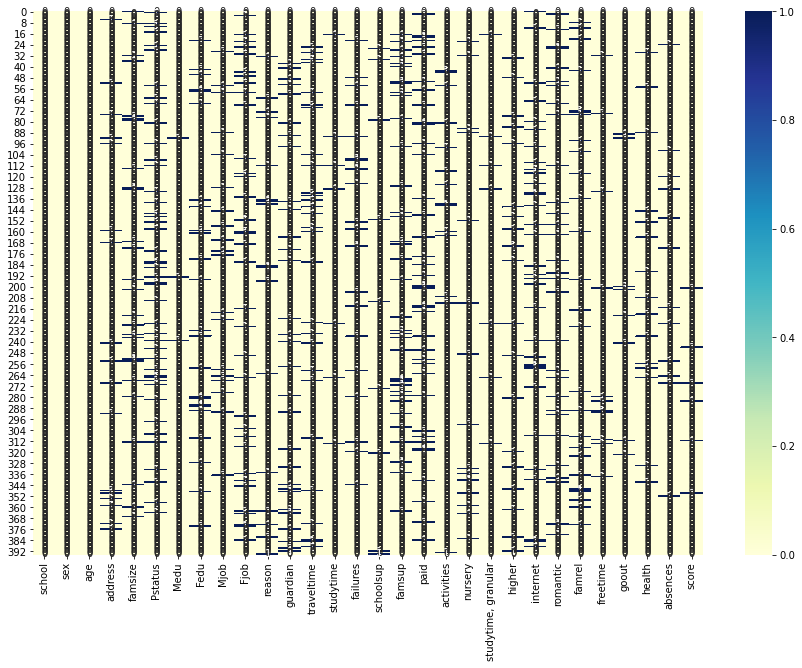

In [10]:
# Проверяем связь между пропущенными ячейками
plt.figure(figsize=(15, 10))  # задаю размер визуализации
sns.heatmap(stud_df.isnull(), cmap='YlGnBu', annot=True)

Как видно на тепловой карте, пропуски распределены равномерно и при этом нет строк с большим количеством пропусков. Соответственно, удалять строки для очистки данных не подойдет в этом случае.

In [11]:
# Проверяем какое количество пропусков в строке максимальное для проверки гипотезы об удалении строк
Count_rows = stud_df.apply(lambda x: sum(x.isnull()), axis=1).value_counts()
percent_nans = round(pd.Series(
    Count_rows.index/stud_df.shape[1]*100)).sort_values(ascending=False).astype(str)+' %'
misses = max(stud_df.apply(lambda x: sum(x.isnull()), axis=1))/stud_df.shape[1]
print('Максимум пустых строк в датафрейме:', round(misses*100, ), "%")

Максимум пустых строк в датафрейме: 20 %


Как видно, гипотеза о том, что нет строк с достаточно большим процентом пропусков (35%+), а потому удалять строки не имеет смысла.

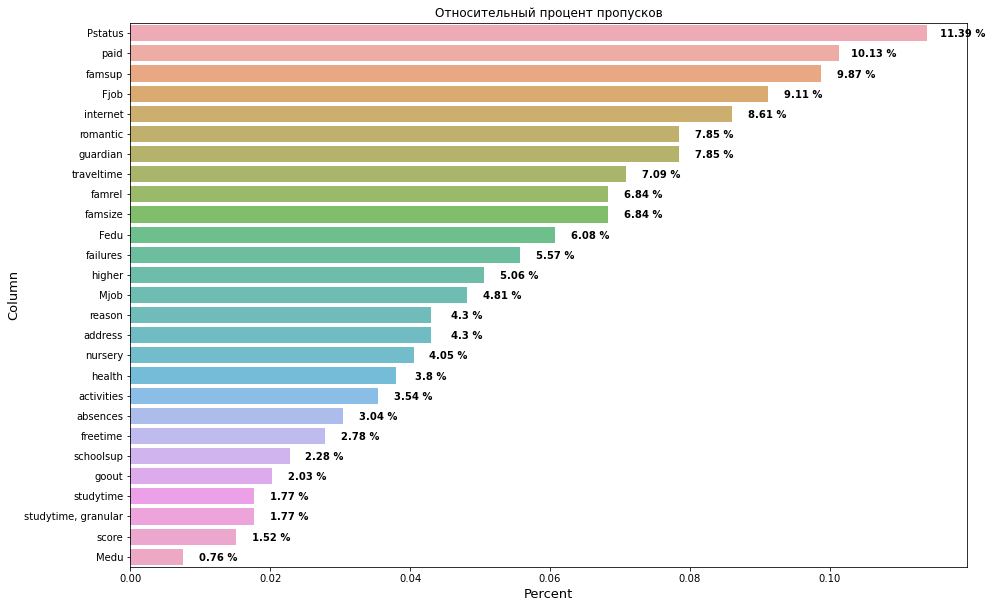

In [12]:
# Считаем процент пропусков
per_nans = pd.DataFrame(1-stud_df.count()/stud_df.shape[0]).reset_index().rename({0: 'percent'},
                                                                                 axis=1).sort_values('percent', ascending=False).query('percent>0')

# Строим график для понимания колонок с наибольшим процентом пропусков
fig, ax = plt.subplots(figsize=(15, 10))
bar_plot = sns.barplot(x='percent', y='index',
                       data=per_nans, alpha=0.8, ci=None)
for ytick in bar_plot.get_yticks():
    bar_plot.text(per_nans.iloc[ytick][1]+0.005, ytick+0.2, str(round(per_nans.iloc[ytick][1]*100, 2))+' %',
                  horizontalalignment='center', size=10, color='black', weight='semibold')
plt.title('Относительный процент пропусков')
plt.ylabel('Column', fontsize=13)
plt.xlabel('Percent', fontsize=13)
plt.show()

Относительный процент пропусков говорит о том, что тратить время на выделение пропусков нецелесообразно.

## Оценка распределения значений для количественных признаков. Работа с аномальными значениями/ошибками

In [13]:
# Добавляем словарь полей, чтобы удобнее проводить дальнейший анализ
descriptions = {
    "school": "аббревиатура школы, в которой учится ученик",
    "sex": "пол ученика ('F' - женский, 'M' - мужской)",
    "age": "возраст ученика (от 15 до 22)",
    "address": "тип адреса ученика ('U' - городской, 'R' - за городом)",
    "famsize": "размер семьи('LE3' <= 3, 'GT3' >3)",
    "Pstatus": "статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)",
    "Medu": "образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)",
    "Fedu": "образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)",
    "Mjob": "работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)",
    "Fjob": "работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)",
    "reason": "причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)",
    "guardian": "опекун ('mother' - мать, 'father' - отец, 'other' - другое)",
    "traveltime": "время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)",
    "studytime": "время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)",
    "failures": "количество внеучебных неудач (n, если 1<=n<=3, иначе 0)",
    "schoolsup": "дополнительная образовательная поддержка (yes или no)",
    "famsup": "семейная образовательная поддержка (yes или no)",
    "paid": "дополнительные платные занятия по математике (yes или no)",
    "activities": "дополнительные внеучебные занятия (yes или no)",
    "nursery": "посещал детский сад (yes или no)",
    "higher": "хочет получить высшее образование (yes или no)",
    "internet": "наличие интернета дома (yes или no)",
    "romantic": "романтических отношениях (yes или no)",
    "famrel": "семейные отношения (от 1 - очень плохо до 5 - очень хорошо)",
    "freetime": "свободное время после школы (от 1 - очень мало до 5 - очень мого)",
    "goout": "проведение времени с друзьями (от 1 - очень мало до 5 - очень много)",
    "health": "текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)",
    "absences": "количество пропущенных занятий",
    "score": "баллы по госэкзамену по математике"
}

In [14]:
# Определяем слова с границами по условию
outline_bounds = {
    "age": [15, 22],
    "Medu": [0, 4],
    "Fedu": [0, 4],
    "traveltime": [1, 4],
    "studytime": [1, 4],
    "failures": [0, 3],
    "famrel": [1, 5],
    "freetime": [1, 5],
    "goout": [1, 5],
    "health": [1, 5],
    "score": [0, 100]
}

### school

аббревиатура школы, в которой учится ученик

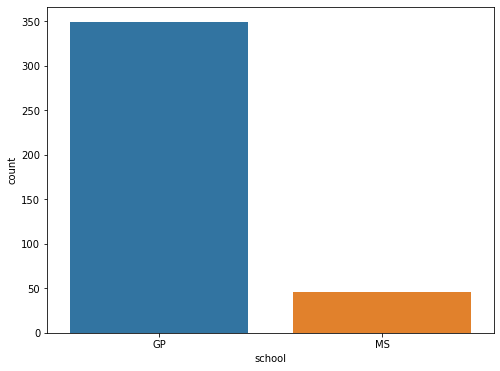

Процент пропусков:  0.0 %


### sex

пол ученика ('F' - женский, 'M' - мужской)

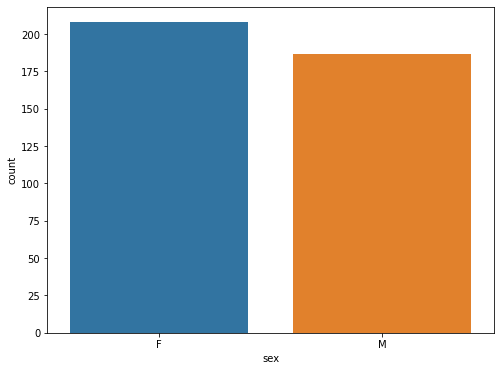

Процент пропусков:  0.0 %


### age

возраст ученика (от 15 до 22)

Ошибки не обнаружены


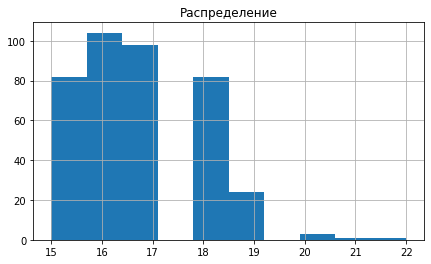

Процент пропусков:  0.0 %


### address

тип адреса ученика ('U' - городской, 'R' - за городом)

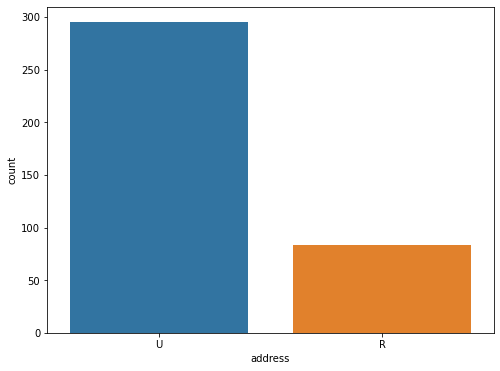

Процент пропусков:  4.3 %


### famsize

размер семьи('LE3' <= 3, 'GT3' >3)

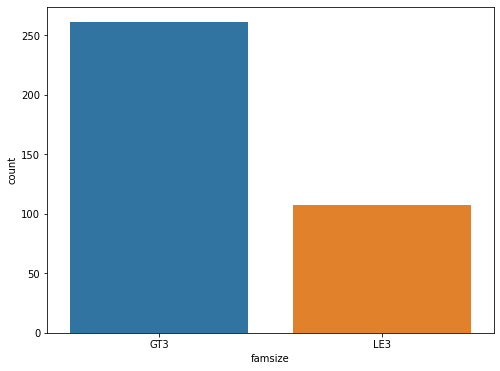

Процент пропусков:  6.84 %


### Pstatus

статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)

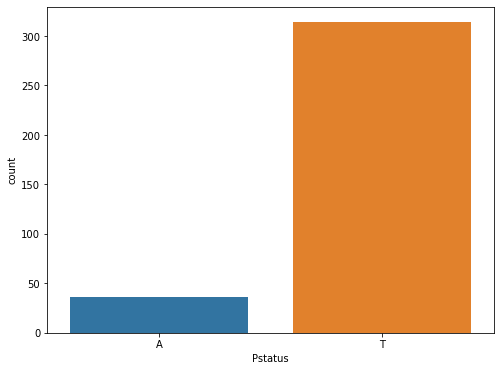

Процент пропусков:  11.39 %


### Medu

образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Ошибки не обнаружены


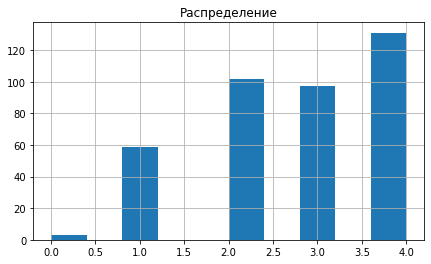

Процент пропусков:  0.76 %


### Fedu

образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)

Найдены выбросы по IQR в количестве:  1


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,U,GT3,NaN,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,-9.0,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


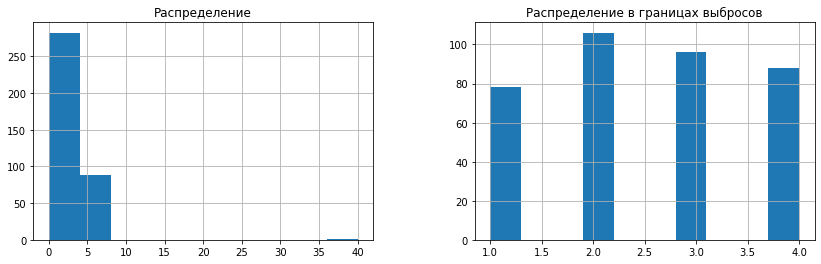

Процент пропусков:  6.08 %


### Mjob

работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

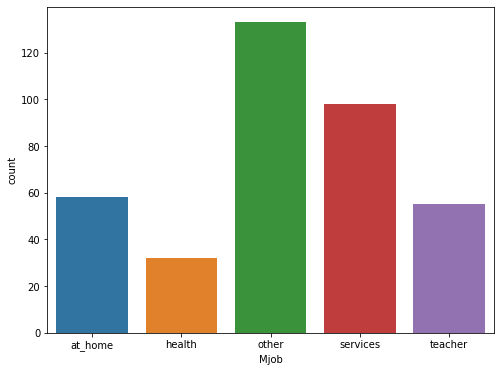

Процент пропусков:  4.81 %


### Fjob

работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)

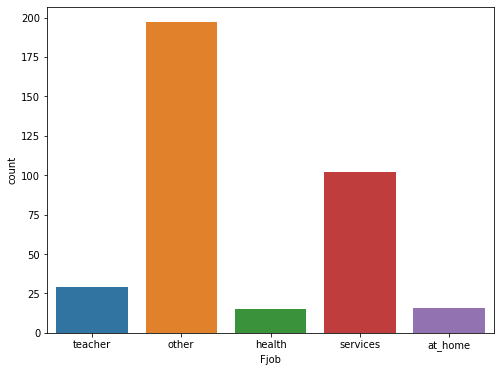

Процент пропусков:  9.11 %


### reason

причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)

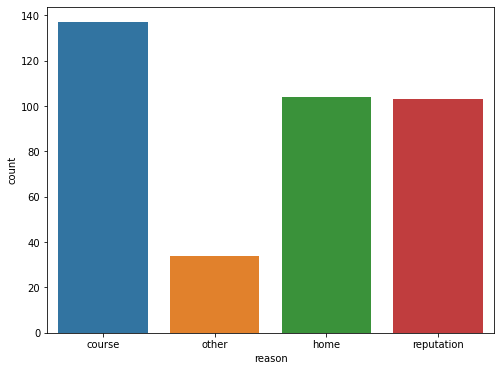

Процент пропусков:  4.3 %


### guardian

опекун ('mother' - мать, 'father' - отец, 'other' - другое)

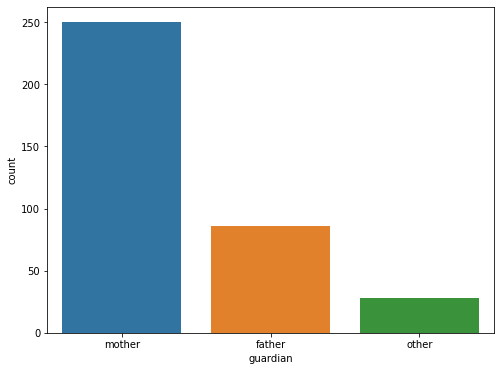

Процент пропусков:  7.85 %


### traveltime

время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)

Ошибки не обнаружены


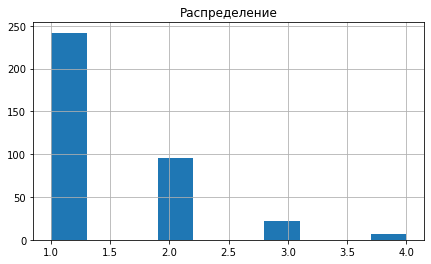

Процент пропусков:  7.09 %


### studytime

время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)

Ошибки не обнаружены


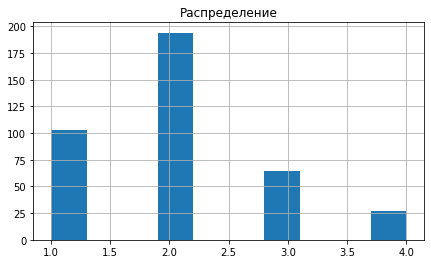

Процент пропусков:  1.77 %


### failures

количество внеучебных неудач (n, если 1<=n<=3, иначе 0)

Ошибки не обнаружены


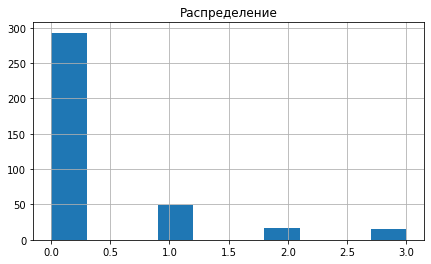

Процент пропусков:  5.57 %


### schoolsup

дополнительная образовательная поддержка (yes или no)

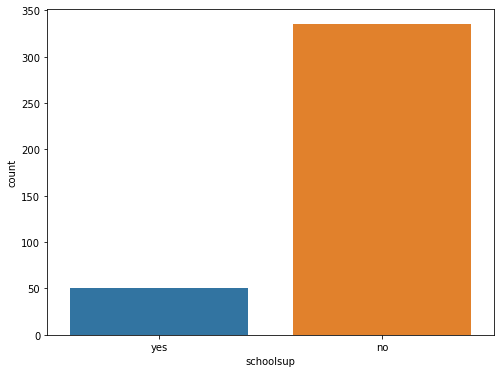

Процент пропусков:  2.28 %


### famsup

семейная образовательная поддержка (yes или no)

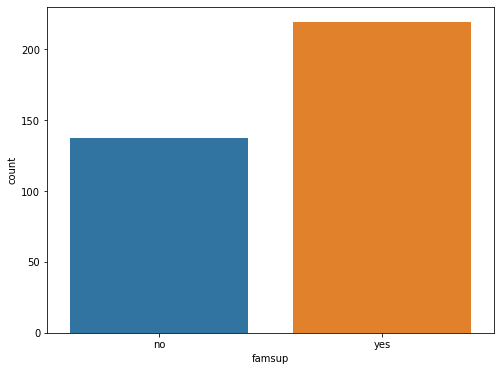

Процент пропусков:  9.87 %


### paid

дополнительные платные занятия по математике (yes или no)

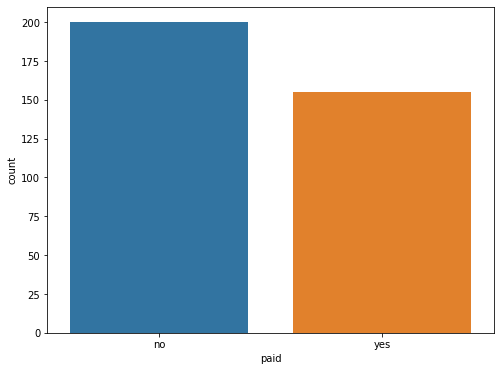

Процент пропусков:  10.13 %


### activities

дополнительные внеучебные занятия (yes или no)

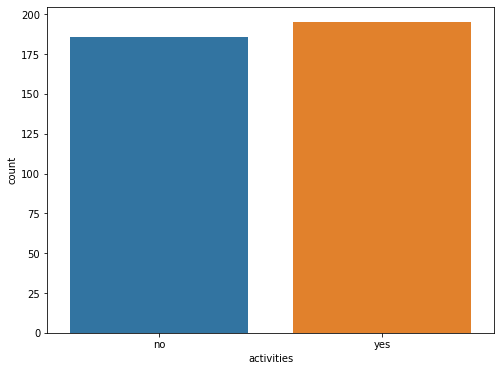

Процент пропусков:  3.54 %


### nursery

посещал детский сад (yes или no)

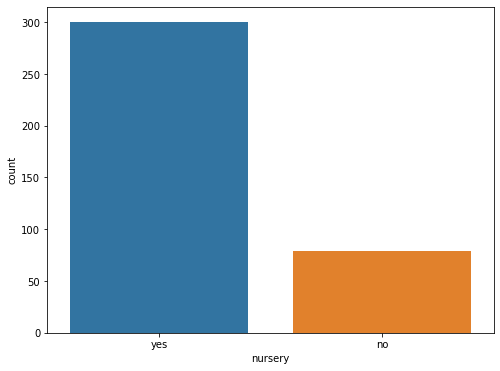

Процент пропусков:  4.05 %


### studytime, granular

Найдены ошибки в количестве: 27

Первые 10:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
47,GP,M,16,U,GT3,T,4.0,3.0,health,NaN,reputation,mother,1.0,4.0,0.0,no,no,no,yes,yes,-12.0,yes,yes,no,4.0,2.0,2.0,2.0,4.0,100.0
66,GP,M,15,U,GT3,A,4.0,4.0,other,services,reputation,mother,1.0,4.0,0.0,no,yes,no,yes,no,-12.0,yes,yes,yes,1.0,3.0,3.0,3.0,4.0,60.0
67,GP,F,16,U,GT3,NaN,3.0,NaN,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,-12.0,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0
69,GP,F,15,R,LE3,T,3.0,1.0,other,other,reputation,father,2.0,4.0,0.0,no,yes,no,no,no,-12.0,yes,yes,no,4.0,4.0,2.0,3.0,12.0,80.0
70,GP,M,16,U,GT3,T,3.0,1.0,other,other,reputation,father,NaN,4.0,0.0,no,yes,yes,no,yes,-12.0,yes,yes,no,4.0,3.0,2.0,5.0,0.0,75.0
71,GP,M,15,U,GT3,T,4.0,2.0,other,other,course,mother,1.0,4.0,0.0,no,no,no,no,yes,-12.0,yes,yes,no,3.0,3.0,3.0,3.0,0.0,50.0
76,GP,M,15,U,NaN,T,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,no,no,no,yes,yes,-12.0,NaN,yes,no,3.0,4.0,3.0,1.0,8.0,50.0
77,GP,F,16,U,GT3,T,2.0,2.0,other,other,NaN,mother,1.0,4.0,0.0,no,no,yes,no,yes,-12.0,yes,yes,yes,5.0,2.0,3.0,3.0,0.0,55.0
94,GP,M,15,U,LE3,T,2.0,2.0,services,health,reputation,mother,1.0,4.0,0.0,no,yes,no,yes,yes,-12.0,yes,yes,no,NaN,3.0,4.0,4.0,6.0,70.0
95,GP,F,15,R,GT3,T,1.0,1.0,at_home,other,home,mother,2.0,4.0,1.0,yes,yes,yes,yes,yes,-12.0,yes,yes,no,3.0,1.0,2.0,1.0,2.0,50.0


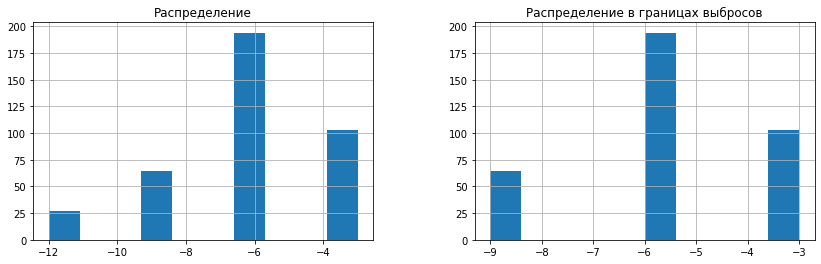

Процент пропусков:  1.77 %


### higher

хочет получить высшее образование (yes или no)

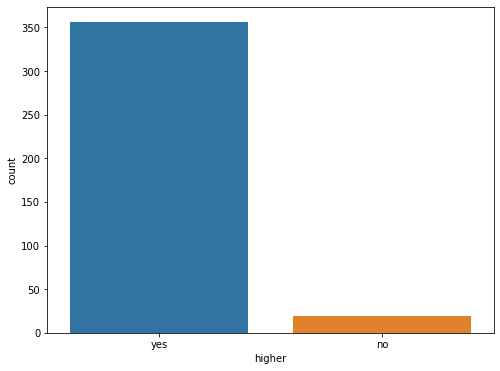

Процент пропусков:  5.06 %


### internet

наличие интернета дома (yes или no)

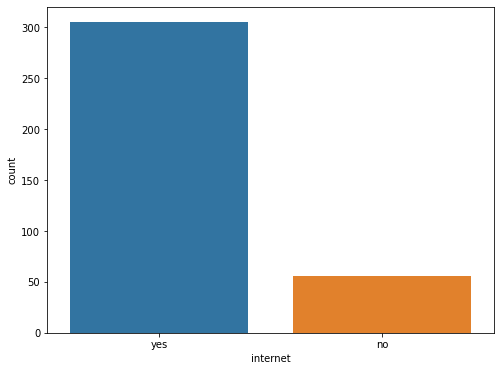

Процент пропусков:  8.61 %


### romantic

романтических отношениях (yes или no)

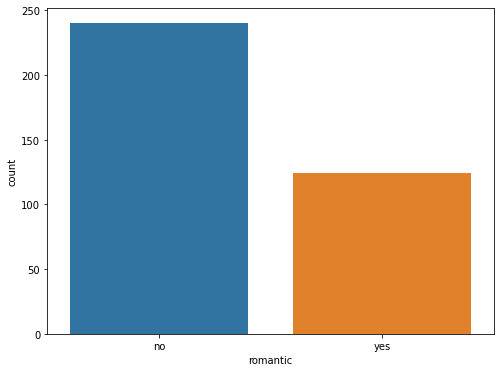

Процент пропусков:  7.85 %


### famrel

семейные отношения (от 1 - очень плохо до 5 - очень хорошо)

Найдены выбросы по IQR в количестве:  1


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,-3.0,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0


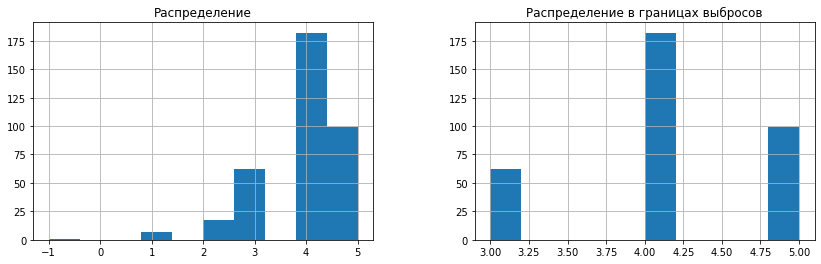

Процент пропусков:  6.84 %


### freetime

свободное время после школы (от 1 - очень мало до 5 - очень мого)

Ошибки не обнаружены


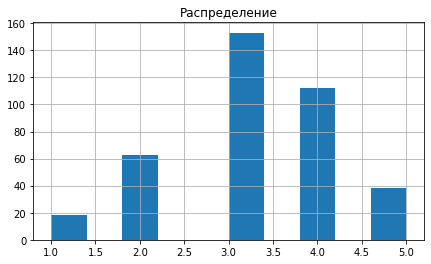

Процент пропусков:  2.78 %


### goout

проведение времени с друзьями (от 1 - очень мало до 5 - очень много)

Ошибки не обнаружены


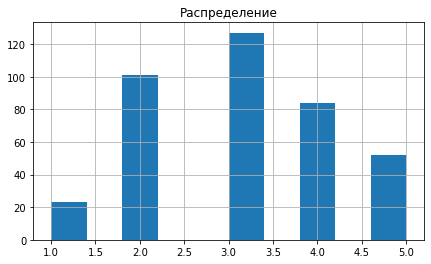

Процент пропусков:  2.03 %


### health

текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)

Ошибки не обнаружены


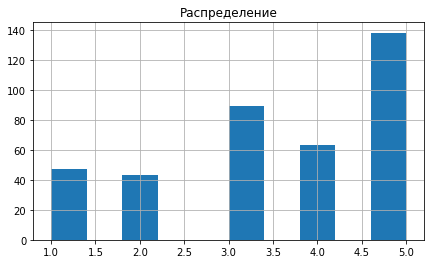

Процент пропусков:  3.8 %


### absences

количество пропущенных занятий

Найдены ошибки в количестве: 17

Первые 10:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,NaN,no,yes,no,-6.0,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
74,GP,F,16,U,GT3,T,3.0,3.0,other,services,home,mother,1.0,2.0,0.0,yes,yes,yes,yes,yes,-6.0,yes,yes,no,4.0,NaN,3.0,5.0,54.0,55.0
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,home,mother,2.0,2.0,0.0,yes,yes,yes,no,yes,-6.0,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
183,GP,F,17,U,LE3,NaN,3.0,3.0,other,other,reputation,mother,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,yes,5.0,3.0,3.0,1.0,56.0,40.0
198,GP,F,17,U,GT3,NaN,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,no,yes,no,no,yes,-3.0,yes,NaN,no,4.0,2.0,4.0,2.0,24.0,90.0
205,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,home,mother,1.0,3.0,1.0,no,yes,yes,no,yes,-9.0,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0
216,GP,F,17,U,GT3,T,4.0,3.0,other,NaN,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,-6.0,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,NaN,no,no,yes,-6.0,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
260,GP,F,18,U,GT3,NaN,4.0,3.0,NaN,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,3.0,1.0,2.0,2.0,21.0,90.0
276,GP,F,18,R,GT3,A,3.0,2.0,other,services,home,mother,2.0,2.0,0.0,no,NaN,no,no,no,-6.0,no,yes,yes,NaN,1.0,1.0,5.0,75.0,45.0


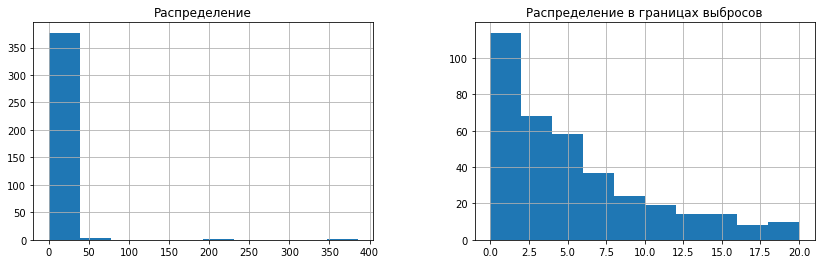

Процент пропусков:  3.04 %


### score

баллы по госэкзамену по математике

Ошибки не обнаружены


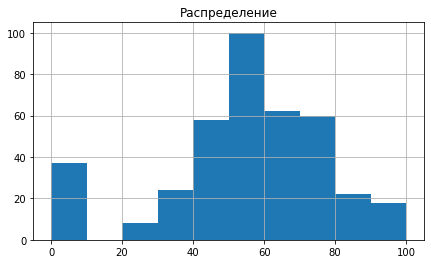

Процент пропусков:  1.52 %


In [15]:
for col in stud_df.columns:
    first_look(stud_df, col, outline_bounds, descriptions)

**Промежуточные выводы:**

В целом данные достаточно хорошие и пригодные для анализа, но есть несколько моментов, которые стоит отметить:
- Из того, что дает нам понять первичный разведывательный анализ данных, можно сказать, что сильно выделяется разброс по школе (одна встречается намного чаще другой), что может говорить о том, что выборка нерелевантна из-за недостаточности разнообразия;
- По возрасту можно заявить, что есть небольшое количество школьников старше  19 лет, но это вполне возможно. По месту жилья и статусу родителей есть большой разброс, но он вполне укладывается в нормалную картину мира и эти данные вполне применимы для анализа;
- Есть выброс по колонке образования отцов. Не до конца ясно что делать с этим выбросом: возможно, это опечатка, может стоит убрать строку или заменить значение на медиану, моду или установить значение NaN. Такая же ситуация с переменной famrel;
- Есть сложночитаемый показатель failures, так как 0 - это и нет неудач, и больше 3;
- Переменная studytime, granular не указана в описании и потому с ней есть проблемы;
- Чаще всего ошибки встречаются в переменной absences. Распределение в границах выбросов очень похоже на нормальное и потому необходимо задать границу, значения выше которой будут выбросами;
- Неописанная в задании переменная studytime, granular по распределению похожа на studytime;
- Есть логика в том, чтобы определить две новые переменные age_cat (категория по возрасту) и is_suo (показатель получения поддержки).

<AxesSubplot:>

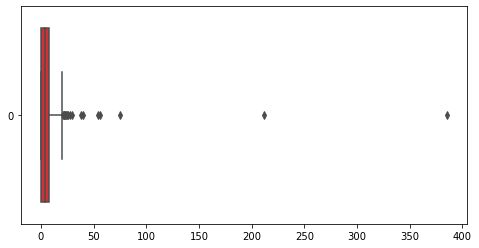

In [16]:
# Анализ переменной absences с самыми частыми ошибками
plt.figure(figsize=(8, 4))
sns.boxplot(data=stud_df['absences'], orient="h", palette="Set1", whis=1.5)

Так как только 2 значения сильно отличаются от общей массы и в датасете мало данных, то лучшим выходом будет заменить их на медианное значение.

In [17]:
# Предобработка данных
stud_df.Fedu = stud_df.Fedu.replace(40, 4)  # выбран вариант с опечаткой
stud_df.famrel = stud_df.famrel.replace(-1, 1)  # выбран вариант с опечаткой
stud_df.absences = stud_df.absences.apply(
    lambda x: stud_df.absences.median() if x > 100 else x)  # медиана
stud_df['age_cat'] = stud_df.age.apply(
    lambda x: 'young' if x < 18 else 'old')  # делаем группировку по возрасту
stud_df['is_sup'] = np.where((stud_df.schoolsup == 'yes') | (
    stud_df.famsup == 'yes'), 'yes', 'no')  # объединение по попмощи
# замена на None пустых значений в score
stud_df.dropna(subset=['score'], inplace=True)

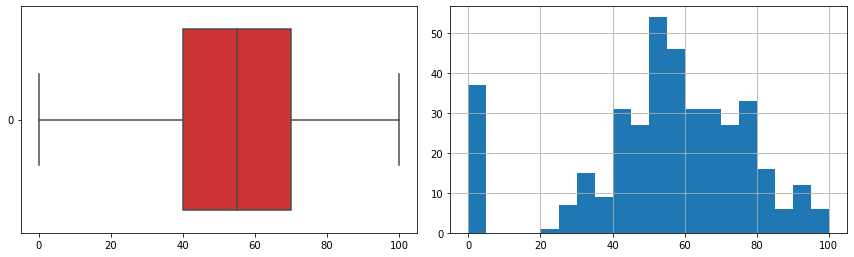

Ошибки не обнаружены


In [18]:
# Построение графиков по целевой переменной score
fig, axes = plt.subplots(ncols=2, figsize=(6, 4))
sns.boxplot(data=stud_df['score'], orient="h",
            palette="Set1", whis=1.5, ax=axes[0])
stud_df.score.hist(bins=20, ax=axes[1])
fig.tight_layout(rect=[-1, 0.03, 1, 0.95])
plt.show()
search_mistakes(stud_df, 'score', outline_bounds)

**Промежуточные выводы**

Сразу видны следующие особенности:
- Около 40 учеников, которые получили оценку 0 на итоговом экзамене;
- Пропуск в районе от 0 до 20 балллов, что может говорить о том, что либо ученики не делают вообще задания правильно, либо делают какой-нибудь минимальный процент;
- Не видно одназначных выбросов или ошибок

Странный разброс между 20 и 0 баллами на экзамене сложно объяснить логично, так как само по себе большое количество оценок 0 подозрительно. Возможно, это связано с проходным значением (например, 20 баллов) и если ученик их не набрал, то ему проставлялся 0. Однако сами по себе эти строки могут понадобиться в дальнейшем, так как возможно получится определить признаки, предсказывающие провал ученика.

## Анализ корреляции признаков

В начале необходимо понять какие покаатели коррелируют с итоговой оценкой на экзамене, что позволит в дальнейшем оставить только их, а остальные исключить

- __анализ корреляции по количественным переменным__

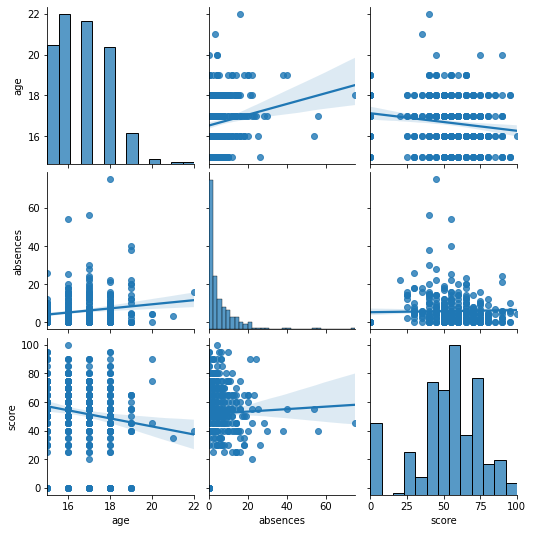

In [19]:
stud_num = ['age', 'absences', 'score']
sns.pairplot(stud_df[stud_num], kind='reg')

In [20]:
stud_df[stud_num].corr()

,age,absences,score
age,1.000000,0.169071,-0.155726
absences,0.169071,1.000000,0.030943
score,-0.155726,0.030943,1.000000


<AxesSubplot:xlabel='absences', ylabel='score'>

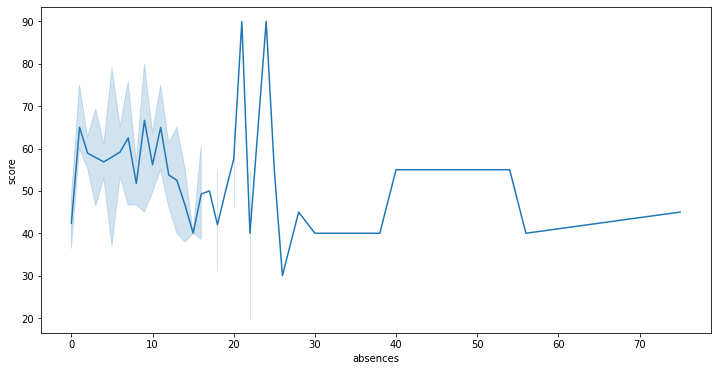

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=stud_df, x='absences', y='score')

Как видно, явной зависимости переменно score от переменной absences нет и потому можно заключить, что итоговый результат не зависит от количества пропусков.

- __анализ корреляции по смешанным и количественным признакам__

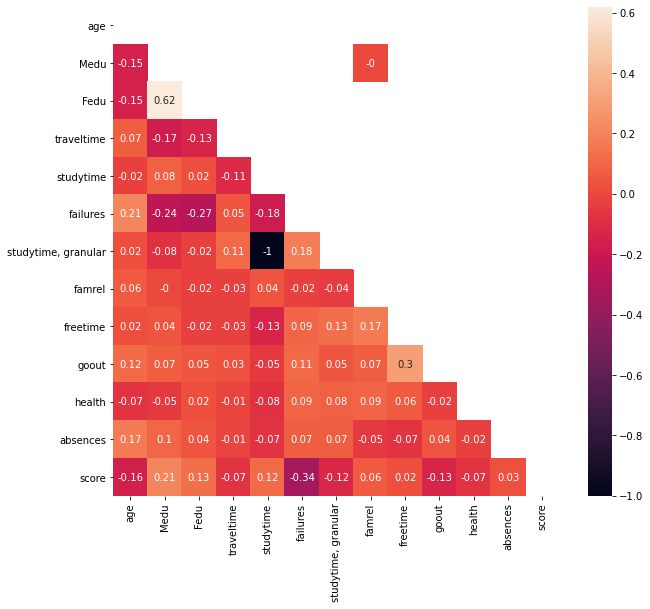

In [22]:
# Строим тепловую карту
quantitative_features = stud_df.select_dtypes(include='number').columns
corr_matrix = stud_df[quantitative_features].corr().round(2)
plt.rcParams['figure.figsize'] = (10, 9)
matrix = np.triu(corr_matrix)
x = sns.heatmap(corr_matrix, mask=matrix, annot=True)

Как видно, неописанная переменная studytime, granular имеет обратную корреляцию с переменной studytime, потому её можно удалить без потери репрезентативности данных. Также, можно заметить заметную зависимость между переменными Fedu, Medu.

In [23]:
# Создаем датафрейм для значений, которые коррелируют между собой
score_correlation_df = pd.DataFrame(stud_df.corr()['score'].values,
                                    index=stud_df.corr()['score'].index,
                                    columns=['correlation'])
score_correlation_df = score_correlation_df.drop("score")
score_correlation_df['correlation_amount'] = abs(
    score_correlation_df.correlation)
printmd("#### Коррелирующие значения")
score_correlation_df.sort_values(by='correlation_amount', ascending=False)

#### Коррелирующие значения

,correlation,correlation_amount
failures,-0.344338,0.344338
Medu,0.213349,0.213349
age,-0.155726,0.155726
Fedu,0.130923,0.130923
goout,-0.129685,0.129685
studytime,0.115741,0.115741
"studytime, granular",-0.115741,0.115741
traveltime,-0.070559,0.070559
health,-0.070460,0.070460
famrel,0.055305,0.055305


Из этой таблицы можно заключить, что более всего на обучение влиияют проблемы, которые возникают вне школы (failures), а также общение с друзьями и возраст - чем больше, тем хуже обучение проходит. И в другую сторону влияют образование родителей и самостоятельное обучение.

В целях очистки данных, стоит удалить столбцы со значением корреляции меньше 0.1.

In [24]:
# Предобработка на основе корреляционного анализа
stud_df.drop('studytime, granular', axis=1, inplace=True)
stud_df.drop(
    score_correlation_df[score_correlation_df.correlation_amount < 0.1].index, axis=1, inplace=True)
# Скалдываем показатели образования родителей для получения новой переменной
stud_df['P_edu'] = stud_df['Fedu'] + stud_df['Medu']

## Визуальный анализ

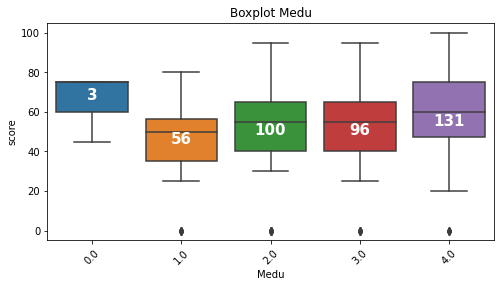

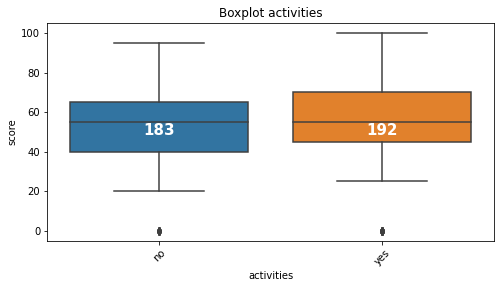

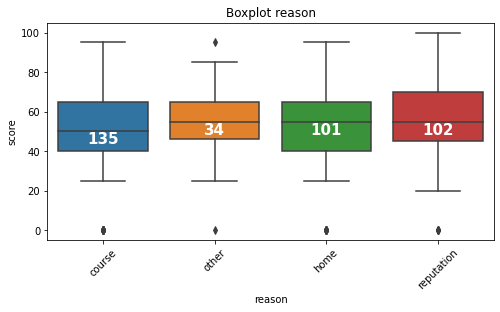

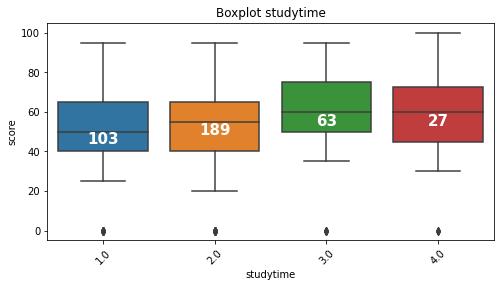

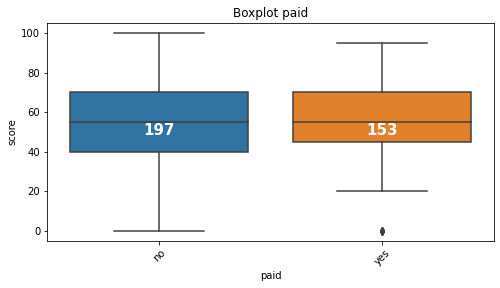

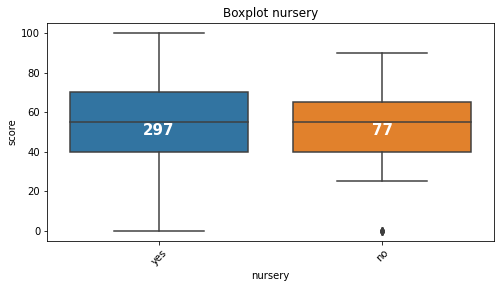

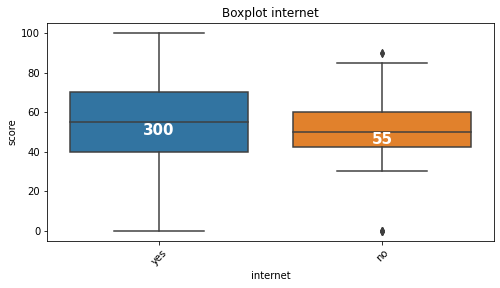

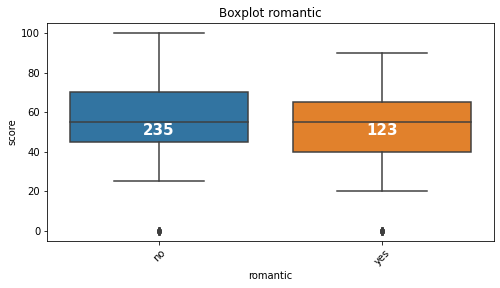

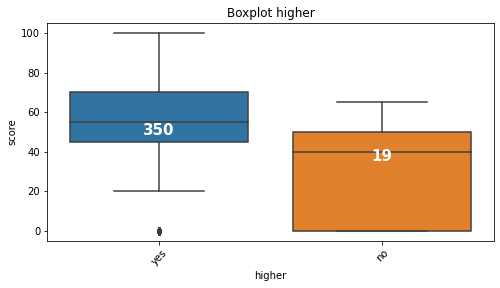

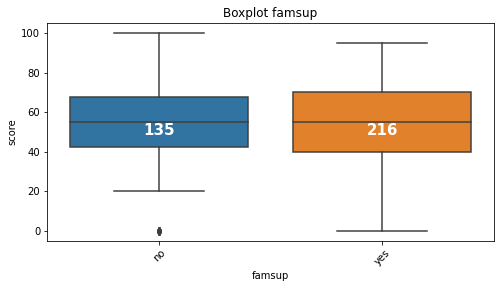

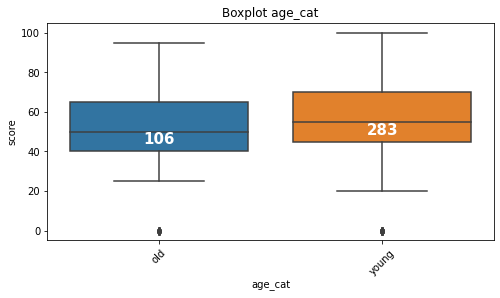

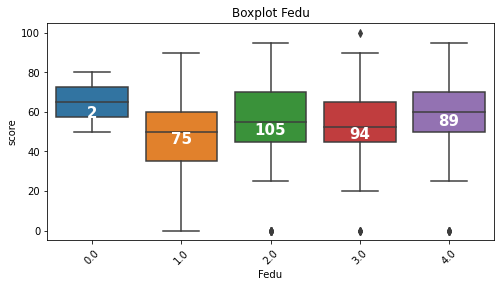

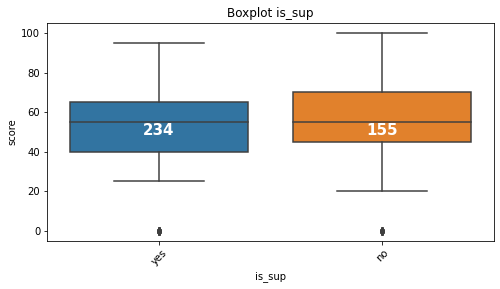

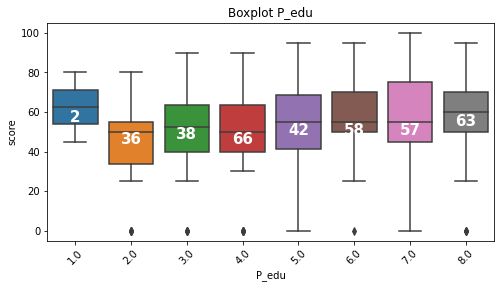

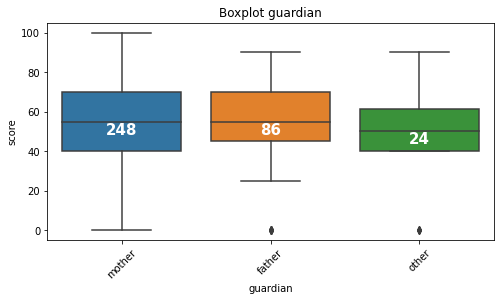

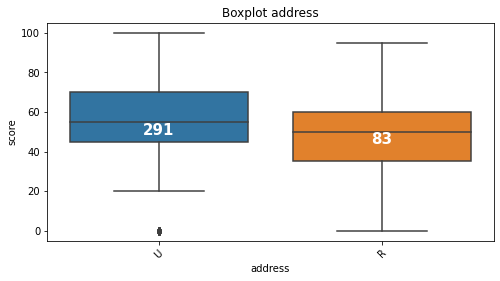

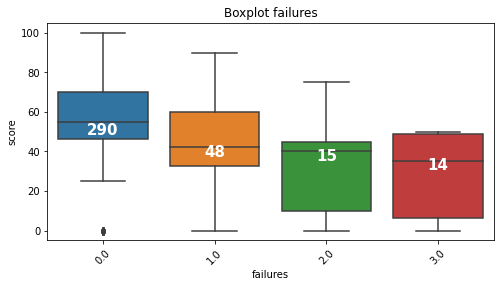

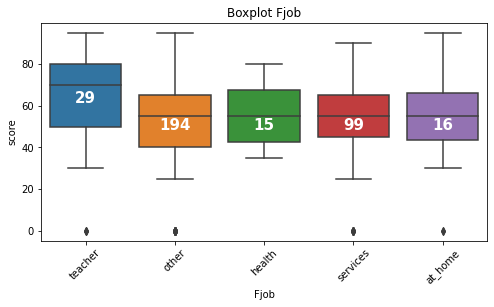

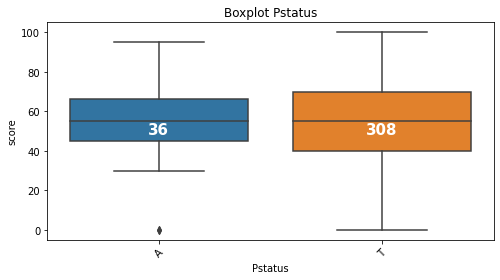

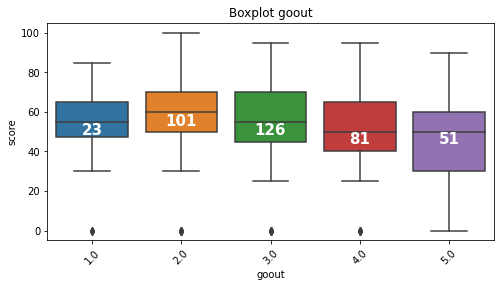

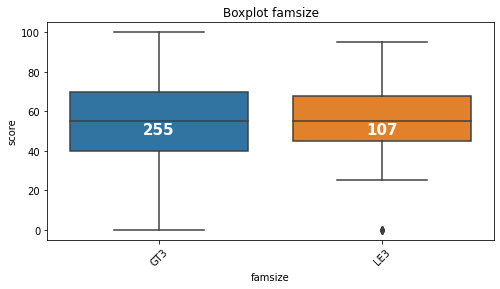

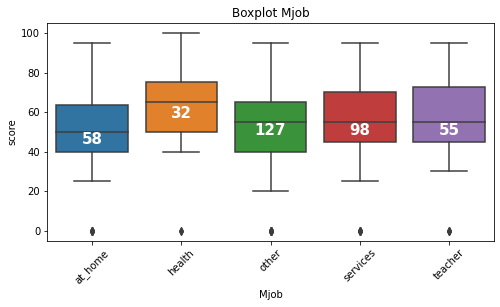

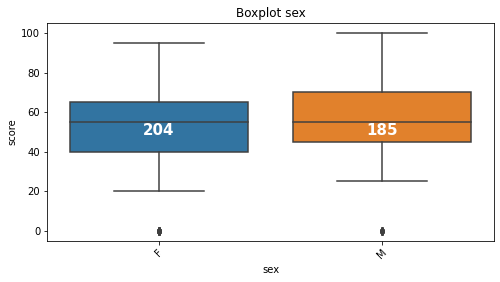

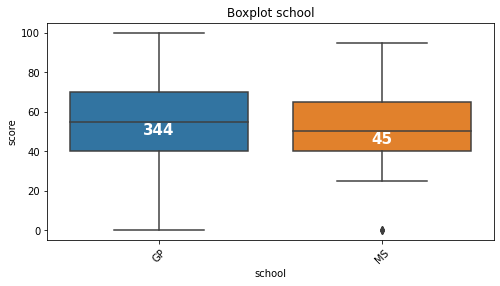

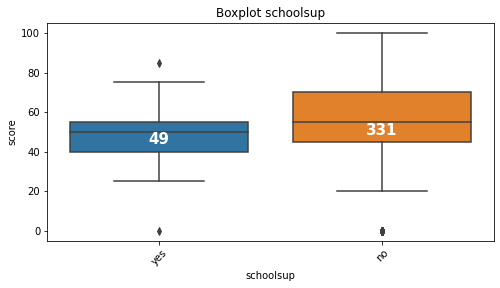

In [25]:
nom_cols = list(set(stud_df.columns) - set(['age', 'absences', 'score']))
for col in nom_cols:
    get_boxplot(stud_df, col)

После осмотра boxplot-графиков можно сказать, что самыми преспективными для моделирования представляются переменные:

- schoolsup
- Fedu
- Pedu
- Medu
- Mjob
- failures
- age_cat
- goout
- school
- address
- studytime

## Критерий Стьюдента

При помощи теста Стьюдента можно прверить есть ли статистически значимая разница в распределении оценок проверив нулевую гипотезу о том, что распределение оценок за экзамен не связано с категориями.

In [26]:
nom_cols = list(set(stud_df.columns) - set(['age', 'absence', 'score']))
lst = []
for col in nom_cols:
    if get_stat_diff(stud_df, col):
        lst.append(col)

Найдены значимые различия для колонки Medu
Найдены значимые различия для колонки paid
Найдены значимые различия для колонки romantic
Найдены значимые различия для колонки higher
Найдены значимые различия для колонки age_cat
Найдены значимые различия для колонки Fedu
Найдены значимые различия для колонки P_edu
Найдены значимые различия для колонки address
Найдены значимые различия для колонки failures
Найдены значимые различия для колонки goout
Найдены значимые различия для колонки Mjob
Найдены значимые различия для колонки sex


Тест Стьюдента и анализ boxplot-графиков дополняют друг друга и потому оставлять переменные только по результатам одного метода неправильно.

In [27]:
# Создаем итоговый датафрейм
list_columns = set(['schoolsup', 'failures', 'address', 'Fedu', 'Medu', 'P_edu', 'Fjob',
                    'Mjob', 'higher', 'age_cat', 'goout', 'school', 'studytime', 'age', 'score'] + lst)
stud_df = stud_df[list_columns]

In [28]:
stud_df.head()

,Medu,age,address,failures,studytime,goout,paid,romantic,Mjob,sex,higher,age_cat,school,Fjob,score,schoolsup,Fedu,P_edu
0,4.0,18,U,0.0,2.0,4.0,no,no,at_home,F,yes,old,GP,teacher,30.0,yes,4.0,8.0
1,1.0,17,U,0.0,2.0,3.0,no,no,at_home,F,yes,young,GP,other,30.0,no,1.0,2.0
2,1.0,15,U,3.0,2.0,2.0,NaN,NaN,at_home,F,yes,young,GP,other,50.0,yes,1.0,2.0
3,4.0,15,U,0.0,3.0,2.0,yes,yes,health,F,yes,young,GP,NaN,75.0,no,2.0,6.0
4,3.0,16,U,0.0,2.0,2.0,yes,no,other,F,yes,young,GP,other,50.0,no,3.0,6.0


## Заполнение пропусков в данных

По-хорошему, данных должно быть достаточно для того, чтобы пропущенные значения опускать или должна быть возможность узнать достоверно значения пропущенные Однако исходный датасет содержит малое количество строк и потому было принято решение заполнить пропуски согласно сильно линейной зависимости или медианой/значениями с наибольшей вероятностью появления.

In [29]:
# Пропущенные значения с сильной зависимостью
stud_df.Fedu = np.where(stud_df.Fedu.isna(), stud_df.Medu, stud_df.Fedu)
stud_df.Medu = np.where(stud_df.Medu.isna(), stud_df.Fedu, stud_df.Medu)

# Пропущенные значения медианой/значениями с наибольшей вероятностью появления
for col in stud_df.columns:
    stud_df[col] = fill_na(stud_df, col, method='auto')

## Итоговый вывод

**В результате проведенного EDA можно сделать следующий выводы:**

- Данные достаточно чистые, так как количество пропусков находится в пределах от 1 до 11 процентов, также есть 3 переменнные без пропусков. Были обнаружены ошибки и заменены на основе логических заключений. В переменной Absences было 2 аномальных значения, которые были заменены на медиану.

- После осмотра распределений были созданы признак наличия поддержки, но его значимость в итоге незначительна. Также была создана дополнительная переменная по категории возраста, которую можно назвать значимой. Были удалены пропуски из целевой переменной, так как они не имеют смысла. Также, есть не д оконца понятный момент с переменной score, где встречается довольно много нулевых значений.

- По итогам корреляционного анализа была удалена переменная stufytime, granular, имеющая полную обратную корреляцию с переменной studytime. Обнаружена линейная зависимость между Fedu, Medu и на основе их создана новая перменная. Исключены переменные явно некоррелирующие (с коэффициентом корреляции менее 0.1)

- Были выделены самые перспективные переменные: age_cat, sex, paid, Medu, Fedu, address, romantic, schoolsup, studytime, school, higher, P_edu, goout

**Итог**
Для дальнейшего моделирования есть смысл использовать переменные: address, Fedu, Medu, higher, romantic, paid, age, studytime, failures, goout. Их можно считать наиболее преспективными.